# Boruta explained

* This was based on the [article](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a).

In [8]:
import pandas as pd
import numpy as np

X = pd.DataFrame({'age': [25, 32, 47, 51, 62],
                  'height': [182, 176, 174, 168, 181],
                  'weight': [75, 71, 78, 72, 86]})
y = pd.Series([20, 32, 45, 55, 61], name = 'income')

In [11]:
np.random.seed(42)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ["shadow_" + column for column in X.columns]

X_boruta = pd.concat([X, X_shadow], axis=1)
X_boruta

,age,height,weight,shadow_age,shadow_height,shadow_weight
0,25,182,75,32,168,71
1,32,176,71,62,176,75
2,47,174,78,47,174,72
3,51,168,72,25,182,86
4,62,181,86,51,181,78


In [62]:
from sklearn.ensemble import RandomForestRegressor

# suggested max_depth between 3 and 7
forest = RandomForestRegressor(max_depth=5, random_state=42)
forest.fit(X_boruta, y)

feature_importance_X = forest.feature_importances_[:len(X.columns)]
feature_importance_shadow = forest.feature_importances_[len(X.columns):]

hits = feature_importance_X > feature_importance_shadow.max()
hits = np.concatenate([hits, [0] * len(hits)])

data = np.concatenate([feature_importance_X, feature_importance_shadow, hits]).reshape(2, 6)
data[0,:] = data[0,:] * 100
X_hits = pd.DataFrame(data.astype(int), 
                      columns=X_boruta.columns,
                      index=pd.Index(["feature importance %", "hits"]))
X_hits

,age,height,weight,shadow_age,shadow_height,shadow_weight
feature importance %,28,15,9,10,21,15
hits,1,0,0,0,0,0


In [68]:
from joblib.func_inspect import filter_args
# hits counter

hits = np.zeros(len(X.columns))
trials = 20

for iter_ in range(trials):
  # random permutation
  np.random.seed(iter_)
  X_shadow = X.apply(np.random.permutation)
  X_boruta = pd.concat([X, X_shadow], axis=1)

  forest = RandomForestRegressor(max_depth=5, random_state=42)
  forest.fit(X_boruta, y)

  feature_importance_X = forest.feature_importances_[:len(X.columns)]
  feature_importance_shadow = forest.feature_importances_[len(X.columns):]

  hits += (feature_importance_X > feature_importance_shadow.max())

df_hits = pd.DataFrame(hits.reshape(1, 3).astype(int), 
                       columns=X.columns,
                       index=pd.Index([f"hits (in {trials} trials)"]))
df_hits

,age,height,weight
hits (in 20 trials),18,5,0


# pmf = probability mass function

$P(k) = C(n, k) * p^k * p^{n-k} \\
\text{where } C(n, k) = \frac{n!}{k!(n-k)!}\\
\text{where } p = \text{probability} \\
\text{where } q = 1 - p $

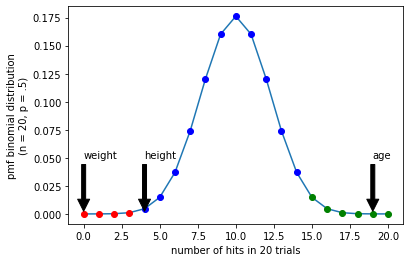

In [141]:
import scipy as sp
import matplotlib.pyplot as plt

pmf = [sp.stats.binom.pmf(x, trials, .5) for x in range(trials + 1)]

plt.plot(pmf, '-')
for idx, value in enumerate(pmf):
  if value < .5 and idx < 4:
    plt.plot(idx, value, 'ro')
  elif value < .5 and idx > 14:
    plt.plot(idx, value, 'go')
  else:
    plt.plot(idx, value, 'bo')

plt.annotate('weight', xy=(0, 0), xytext=(0, 0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('height', xy=(4, 0), xytext=(4, 0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('age', xy=(19, 0), xytext=(19, 0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.ylabel(f"pmf binomial distribution\n(n = {trials}, p = .5)")
plt.xlabel(f"number of hits in {trials} trials")
plt.show()

In [120]:
!pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 5.2 MB/s 


In [122]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np

forest = RandomForestRegressor(
  n_jobs=-1,
  max_depth=5
)
boruta = BorutaPy(
  estimator=forest, 
  n_estimators='auto', 
  max_iter=100
)

boruta.fit(np.array(X), np.array(y))
green_area = X.columns[boruta.support_].tolist()
blue_area = X.columns[boruta.support_weak_].tolist()

print('features in the green area: ', green_area)
print('features in the blue area: ', blue_area)

features in the green area:  []
features in the blue area:  ['age']
